In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import torch
import random
from torch import nn, optim
import torch.nn.functional as F
import math
from IPython import display

from plot_lib import plot_data, plot_model, set_default

set_default()

### Create a synthetic data

In [2]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

DEVICE = "cpu"
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units


In [3]:
X = torch.zeros(N * C, D).to(DEVICE)
y = torch.zeros(N * C, dtype=torch.long).to(DEVICE)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = torch.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2
    
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (3000, 2)
y: (3000,)


In [4]:
num_classes = len(torch.unique(y))
print(f"num_classes: {num_classes}")

num_classes: 3


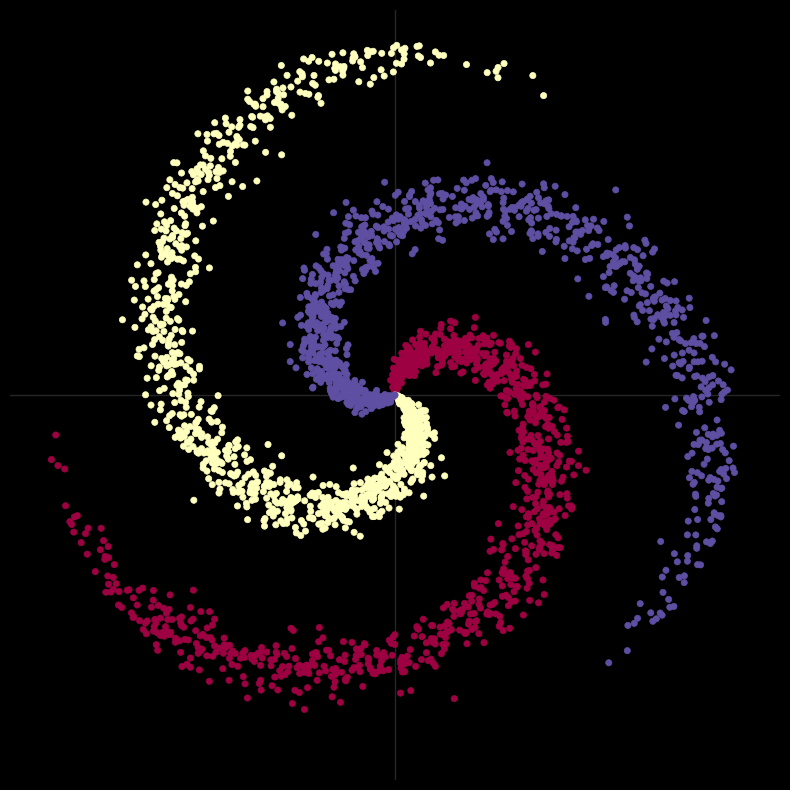

In [5]:
plot_data(X, y)

### Model: Logistic classifier

In [6]:
# 1. define model
class Logistic(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Logistic, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        logit = self.linear(x)
        return logit
    

class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        return out

# model = Logistic(D, C)
model = FeedForward(D, H, C)
model = model.to(DEVICE)

print(model)

FeedForward(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)


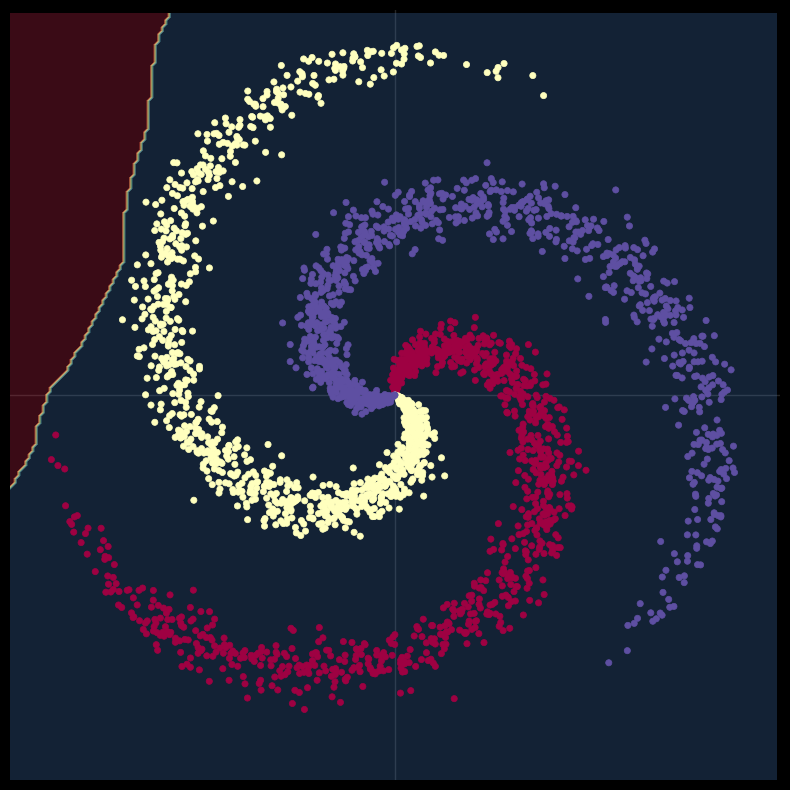

In [7]:
# plot model (before training)
plot_model(X, y, model)

In [8]:
# Forward pass
with torch.no_grad():
    logit_hat = model(X)

In [9]:
print(f"y dim: {y.dim()}")
print(f"logit_hat dim: {logit_hat.dim()}")

y dim: 1
logit_hat dim: 2


In [10]:
# Loss function
loss = F.cross_entropy(logit_hat, y)
print(f"Loss: {loss.item()}")

Loss: 1.078474760055542


In [11]:
# Define optimizer
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

lrate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lrate)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# # Train model: backpropagation
# optimizer.zero_grad()
# loss.backward()
# optimizer.step()

# logit_hat = model(X)

# loss = F.cross_entropy(logit_hat, y)
# print(f"Loss: {loss.item()}")

Epoch-0 out of 5000: Loss: 1.078474760055542
Epoch-10 out of 5000: Loss: 1.0235576629638672
Epoch-20 out of 5000: Loss: 0.9759795069694519
Epoch-30 out of 5000: Loss: 0.9342039227485657
Epoch-40 out of 5000: Loss: 0.8971359729766846
Epoch-50 out of 5000: Loss: 0.8641360402107239
Epoch-60 out of 5000: Loss: 0.8347585201263428
Epoch-70 out of 5000: Loss: 0.8085964322090149
Epoch-80 out of 5000: Loss: 0.7852560877799988
Epoch-90 out of 5000: Loss: 0.764310359954834
Epoch-100 out of 5000: Loss: 0.7454257607460022
Epoch-110 out of 5000: Loss: 0.7281928658485413
Epoch-120 out of 5000: Loss: 0.7122654914855957
Epoch-130 out of 5000: Loss: 0.6974279880523682
Epoch-140 out of 5000: Loss: 0.6834161877632141
Epoch-150 out of 5000: Loss: 0.6699923276901245
Epoch-160 out of 5000: Loss: 0.6569898128509521
Epoch-170 out of 5000: Loss: 0.6442716717720032
Epoch-180 out of 5000: Loss: 0.6317858695983887
Epoch-190 out of 5000: Loss: 0.6194989681243896
Epoch-200 out of 5000: Loss: 0.6073863506317139
Epoch

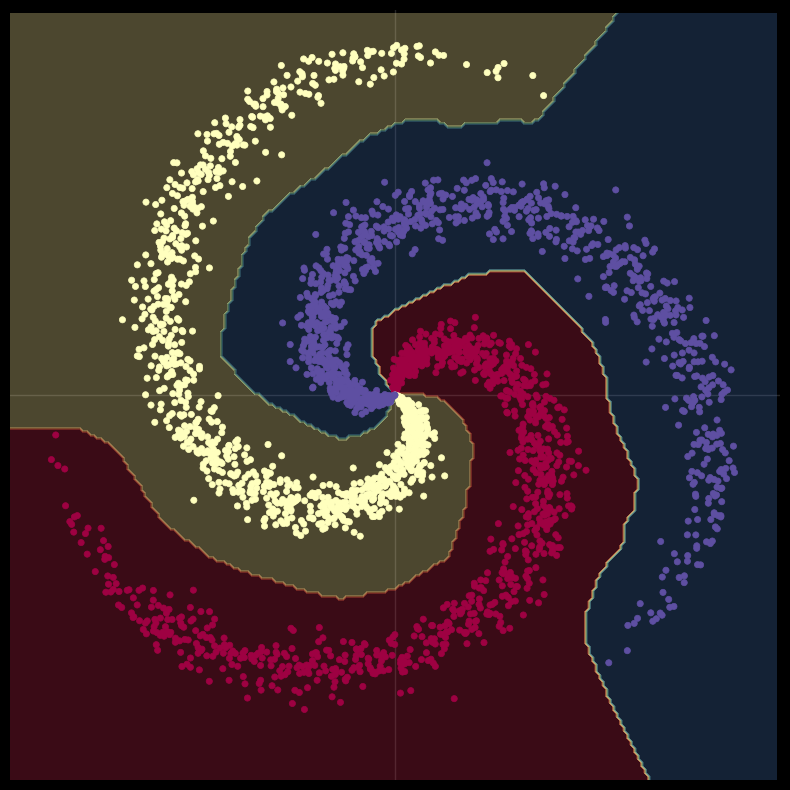

In [13]:
# Train model: backpropagation

EPOCHS = 5000

for epoch in range(EPOCHS):
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward pass
    logit_hat = model(X)

    # loss function
    loss = F.cross_entropy(logit_hat, y)

    # backpropagation
    loss.backward()
    optimizer.step() # gradient update

    if epoch % 10 == 0:
        # display.clear_output(wait=True)
        print(f"Epoch-{epoch} out of {EPOCHS}: Loss: {loss.item()}")

plot_model(X, y, model)


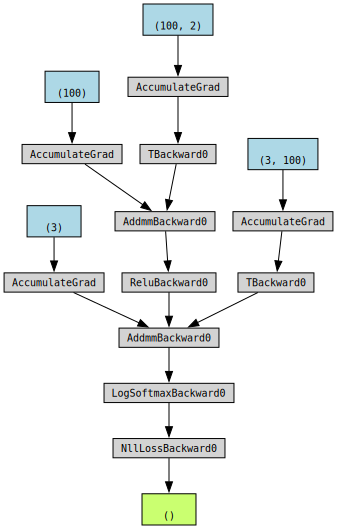

In [14]:
from torchviz import make_dot

make_dot(loss)